### Import dependencies

In [62]:
import warnings
warnings.filterwarnings('ignore')
import os 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
from tensorflow import keras
from skimage.transform import resize
from skimage.io import imshow
from PIL import Image
import pandas as pd

Define global variables

In [2]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNEL = 3

### Reading and preprocessing images and masks

In [3]:
# get the address of the images and masks from the folders
def get_files_addresses(path):
    address_list = []
    os.chdir(path) 
    for file in os.listdir():                # save the image passes in a list
        file_path = f"{path}/{file}"
        address_list.append(file_path)
    
    return address_list

Reading images and masks

In [5]:
image_add = get_files_addresses("C:\\Users\\ASC\\OneDrive\\Desktop\\temp\\kvasir-seg\\Kvasir-SEG\\images")
mask_add = get_files_addresses("C:\\Users\\ASC\\OneDrive\\Desktop\\temp\\kvasir-seg\\Kvasir-SEG\\masks")

images, masks = [], []

for img in image_add:
    img1 = cv2.imread(img)
    images.append(img1)

for img in mask_add:
    img1 = Image.open(img) 
    img = img1.convert('L')             # gray scale the masks
    y = np.expand_dims(img, axis=-1)
    masks.append(y)

Resize the images and masks to (128, 128), and split data to train and task

In [6]:
X_train = np.zeros((900, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)
Y_train = np.zeros((900, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
X_test = np.zeros((100, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)
Y_test = np.zeros((100, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for i in range(900):               # 90% of the data for training
    img = images[i]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img
    mask = masks[i]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[i] = mask

for i in range(900, 1000):         # 10% of the data for testing
    img = images[i]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[i-900] = img
    mask = masks[i]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_test[i-900] = mask

Checking images and masks in train and test data

Text(0.5, 1.0, 'testing mask 73')

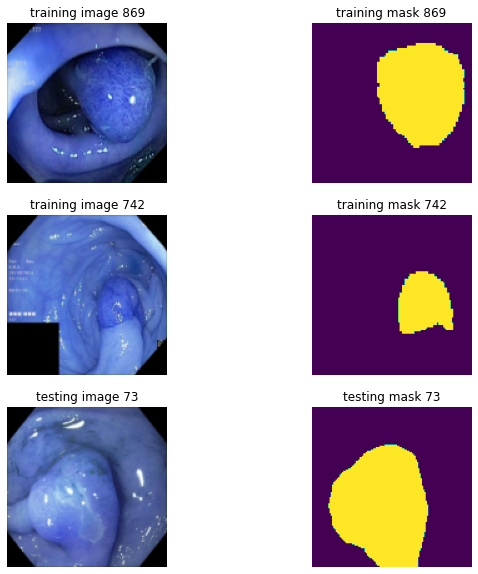

In [8]:
fig = plt.figure(figsize=(10, 10))
train_rand1 = random.randint(0, 900)
train_rand2 = random.randint(0, 900)
test_rand = random.randint(0, 100)

fig.add_subplot(3, 2, 1) 
  
# showing image 
plt.imshow(X_train[train_rand1]) 
plt.axis('off') 
plt.title(f"training image {train_rand1}") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(3, 2, 2) 
  
# showing image 
plt.imshow(Y_train[train_rand1]) 
plt.axis('off') 
plt.title(f"training mask {train_rand1}") 
  
# Adds a subplot at the 3rd position 
fig.add_subplot(3, 2, 3) 
  
# showing image 
plt.imshow(X_train[train_rand2]) 
plt.axis('off') 
plt.title(f"training image {train_rand2}") 
  
# Adds a subplot at the 4th position 
fig.add_subplot(3, 2, 4) 
  
# showing image 
plt.imshow(Y_train[train_rand2]) 
plt.axis('off') 
plt.title(f"training mask {train_rand2}") 
  
# Adds a subplot at the 5rd position 
fig.add_subplot(3, 2, 5) 
  
# showing image 
plt.imshow(X_test[test_rand]) 
plt.axis('off') 
plt.title(f"testing image {test_rand}") 
  
# Adds a subplot at the 6th position 
fig.add_subplot(3, 2, 6) 
  
# showing image 
plt.imshow(Y_test[test_rand]) 
plt.axis('off') 
plt.title(f"testing mask {test_rand}") 

### Model Evaluation

Dice coefficient

In [21]:
def dice_coef(preds_test_t):
    tp, tn, fp, fn = 0, 0, 0, 0

    for i in range(preds_test_t.shape[0]):
        for j in range(preds_test_t.shape[1]):
            for k in range(preds_test_t.shape[2]):
                if preds_test_t[i][j][k] == Y_test[i][j][k] == 1:
                    tp += 1
                elif preds_test_t[i][j][k] == Y_test[i][j][k] == 0:
                    tn += 1
                elif preds_test_t[i][j][k] == 1:
                    fp += 1
                else:
                    fn += 1
    
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    acc = (tp+tn) / (tp+tn+fp+fn)
    dice = (2*precision*recall)/(precision+recall)   # calculate dice coeeficient or F1 score

    return precision*100, recall*100, dice*100, acc*100

Intersection over union(IoU)

In [18]:
def IoU(preds_test_t):
    intersection, union = 0, 0

    for i in range(preds_test_t.shape[0]):
        for j in range(preds_test_t.shape[1]):
            for k in range(preds_test_t.shape[2]):
                if preds_test_t[i][j][k] == Y_test[i][j][k] == 1:  # intersection reigon
                    intersection += 1
                if preds_test_t[i][j][k] == 1 or  Y_test[i][j][k] == 1:   # union reigon
                    union += 1

    intersection_over_union = intersection / union   # calculate IoU

    return intersection_over_union*100

Functions for evaluating models

In [123]:
def model_evaluation(model, X_train, X_test, Y_test, model_name):
    preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
    preds_vals = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
    preds_test = model.predict(X_test, verbose=1)

    preds_train_t = (preds_train > 0.5).astype(np.uint8)   # fix the value of pixles to 0 or 1
    preds_val_t = (preds_vals > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    precision, recall, dice, accuracy = dice_coef(preds_test_t)
    intersection_o_union = IoU(preds_test_t)

    print("Evaluate on test data...")
    results = model.evaluate(X_test, Y_test, batch_size=128)

    table = [[np.round(accuracy, 2), np.round(precision, 2), np.round(recall, 2), np.round(dice, 2), np.round(intersection_o_union, 2)]]
    df = pd.DataFrame(table, columns = ['Accuracy', 'Precision', 'Recall', 'Dice_Coefficient', 'Intersection_over_Union'], index=[model_name])
    print(df)
    return preds_test_t, df

### Model Visualization

In [42]:
def model_visualization(X_test, Y_test, Y_pred):
    fig = plt.figure(figsize=(10, 10))
    x_rand1 = random.randint(0, 100)
    x_rand2 = random.randint(0, 100)
    x_rand3 = random.randint(0, 100)

    fig.add_subplot(3, 3, 1) 
    
    # showing image 
    plt.imshow(X_test[x_rand1]) 
    plt.axis('off') 
    plt.title(f"image {x_rand1}") 
    
    # Adds a subplot at the 2nd position 
    fig.add_subplot(3, 3, 2) 
    
    # showing image 
    plt.imshow(Y_test[x_rand1]) 
    plt.axis('off') 
    plt.title(f"mask {x_rand1}") 
    
    # Adds a subplot at the 3rd position 
    fig.add_subplot(3, 3, 3) 
    
    # showing image 
    plt.imshow(Y_pred[x_rand1]) 
    plt.axis('off') 
    plt.title(f"predicted mask {x_rand1}") 

    fig.add_subplot(3, 3, 4) 
    
    # showing image 
    plt.imshow(X_test[x_rand2]) 
    plt.axis('off') 
    plt.title(f"image {x_rand2}") 
    
    # Adds a subplot at the 2nd position 
    fig.add_subplot(3, 3, 5) 
    
    # showing image 
    plt.imshow(Y_test[x_rand2]) 
    plt.axis('off') 
    plt.title(f"mask {x_rand2}") 
    
    # Adds a subplot at the 3rd position 
    fig.add_subplot(3, 3, 6) 
    
    # showing image 
    plt.imshow(Y_pred[x_rand2]) 
    plt.axis('off') 
    plt.title(f"predicted mask {x_rand2}") 

    fig.add_subplot(3, 3, 7) 
    
    # showing image 
    plt.imshow(X_test[x_rand3]) 
    plt.axis('off') 
    plt.title(f"image {x_rand3}") 
    
    # Adds a subplot at the 2nd position 
    fig.add_subplot(3, 3, 8) 
    
    # showing image 
    plt.imshow(Y_test[x_rand3]) 
    plt.axis('off') 
    plt.title(f"mask {x_rand3}") 
    
    # Adds a subplot at the 3rd position 
    fig.add_subplot(3, 3, 9) 
    
    # showing image 
    plt.imshow(Y_pred[x_rand3]) 
    plt.axis('off') 
    plt.title(f"predicted mask {x_rand3}") 
    return


### U-Net 

Implement U-Net model

In [9]:
def U_Net():
    f = [16, 32, 64, 128, 256]
    # ENCODER part
    # input layer
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))
    s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)                        # scaling images

    # layer 1
    c1 = tf.keras.layers.Conv2D(f[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(f[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    # layer 2
    c2 = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # layer 3
    c3 = tf.keras.layers.Conv2D(f[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(f[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    # layer 4
    c4 = tf.keras.layers.Conv2D(f[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(f[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    # bottleneck
    # layer 5
    c5 = tf.keras.layers.Conv2D(f[4], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(f[4], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # DECODER part
    # layer 6
    u6 = tf.keras.layers.Conv2DTranspose(f[3], (2,2), strides=(2,2), padding='same')(c5)
    u6 = tf.keras.layers.Concatenate()([u6, c4])
    c6 = tf.keras.layers.Conv2D(f[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(f[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # layer 7
    u7 = tf.keras.layers.Conv2DTranspose(f[2], (2,2), strides=(2,2), padding='same')(c6)
    u7 = tf.keras.layers.Concatenate()([u7, c3])
    c7 = tf.keras.layers.Conv2D(f[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(f[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # layer 8
    u8 = tf.keras.layers.Conv2DTranspose(f[1], (2,2), strides=(2,2), padding='same')(c7)
    u8 = tf.keras.layers.Concatenate()([u8, c2])
    c8 = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # layer 9
    u9 = tf.keras.layers.Conv2DTranspose(f[0], (2,2), strides=(2,2), padding='same')(c8)
    u9 = tf.keras.layers.Concatenate()([u9, c1])
    c9 = tf.keras.layers.Conv2D(f[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(f[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # output layer
    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

Fitting the U-Net model

In [11]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('U-Net-model.h5', verbose=1, save_best_only=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]

U_Net_model = U_Net()
U_Net_results = U_Net_model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=callbacks)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

U-Net's results

In [81]:
Y_pred_unet, df = model_evaluation(U_Net_model, X_train, X_test, Y_test, "U-Net")
models_results = {}
models_results["U-Net"] = df

4/4 [==============================] - 2s 513ms/step
Evaluate on test data...
1/1 [==============================] - 3s 3s/step - loss: 0.2627 - accuracy: 0.9075
       Accuracy  Precision  Recall  Dice_Coefficient  Intersection_over_Union
U-Net     90.75      86.68   82.51             83.54                    70.41


check created masks for test data

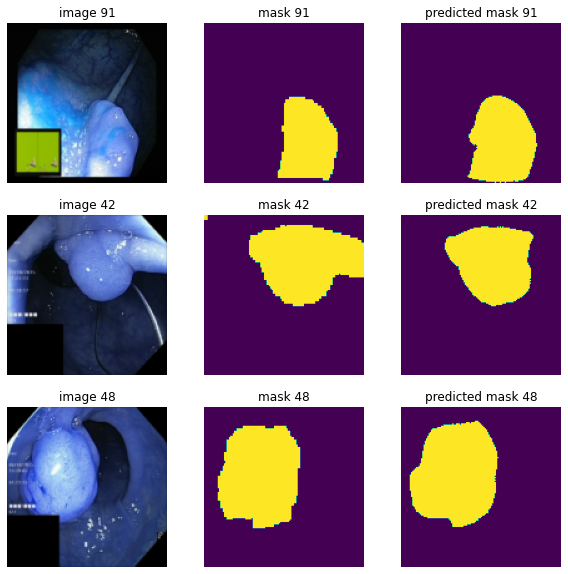

In [44]:
model_visualization(X_test, Y_test, Y_pred_unet)

### Double Encoder Decoder

In [46]:
def DED():
    f = [16, 32, 64, 128, 256]
    # ENCODER 1
    # input layer
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))
    s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)  # scaling the image

    # layer 1
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    # layer 2
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # layer 3
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    # layer 4
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    # layer 5 (bottleneck)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # DECODER 1
    # layer 6
    u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = tf.keras.layers.Concatenate()([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # layer 7
    u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = tf.keras.layers.Concatenate()([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # layer 8
    u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = tf.keras.layers.Concatenate()([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # layer 9
    u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = tf.keras.layers.Concatenate()([u9, c1])
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # output layer
    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

    # ENCODER 2
    # layer 10
    s2 = tf.keras.layers.Concatenate()([outputs, s])  # merge the output of decoder 1 with input and fees it as input of encoder 2
    l1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s2)
    l1 = tf.keras.layers.Dropout(0.1)(l1)
    l1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l1)
    q1 = tf.keras.layers.MaxPooling2D((2, 2))(l1)

    # layer 11
    l2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(q1)
    l2 = tf.keras.layers.Dropout(0.1)(l2)
    l2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l2)
    q2 = tf.keras.layers.MaxPooling2D((2, 2))(l2)

    # layer 12
    l3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(q2)
    l3 = tf.keras.layers.Dropout(0.2)(l3)
    l3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l3)
    q3 = tf.keras.layers.MaxPooling2D((2, 2))(l3)

    # layer 13
    l4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(q3)
    l4 = tf.keras.layers.Dropout(0.2)(l4)
    l4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l4)
    q4 = tf.keras.layers.MaxPooling2D((2, 2))(l4)

    # layer 14 (bottleneck)
    l5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(q4)
    l5 = tf.keras.layers.Dropout(0.3)(l5)
    l5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l5)

    # decoder 2
    # layer 15
    v6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(l5)
    v6 = tf.keras.layers.Concatenate()([v6, l4])
    l6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(v6)
    l6 = tf.keras.layers.Dropout(0.2)(l6)
    l6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l6)

    # layer 16
    v7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(l6)
    v7 = tf.keras.layers.Concatenate()([v7, l3])
    l7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(v7)
    l7 = tf.keras.layers.Dropout(0.2)(l7)
    l7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l7)

    # layer 17
    v8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(l7)
    v8 = tf.keras.layers.Concatenate()([v8, l2])
    l8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(v8)
    l8 = tf.keras.layers.Dropout(0.1)(l8)
    l8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l8)

    # layer 18
    v9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(l8)
    v9 = tf.keras.layers.Concatenate()([v9, l1])
    l9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(v9)
    l9 = tf.keras.layers.Dropout(0.1)(l9)
    l9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l9)

    # output layer
    outputs2 = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(l9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs2])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

Fitting Double-Encoder-Decoder Model

In [47]:
checkpointer2 = tf.keras.callbacks.ModelCheckpoint('DED-model.h5', verbose=1, save_best_only=True)
callbacks2 = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]

DED_model = DED()
DED_results = DED_model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=callbacks2)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 128, 128, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  448         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

Double-Encoder-Decoder's results

In [82]:
Y_pred_ded, df = model_evaluation(DED_model, X_train, X_test, Y_test, "DED")
models_results["DED"] = df

4/4 [==============================] - 7s 1s/step
Evaluate on test data...
1/1 [==============================] - 7s 7s/step - loss: 0.2590 - accuracy: 0.9057
     Accuracy  Precision  Recall  Dice_Coefficient  Intersection_over_Union
DED     90.57      85.16   83.95             83.55                    70.43


Check created masks for test data with double-encoder-decoder model

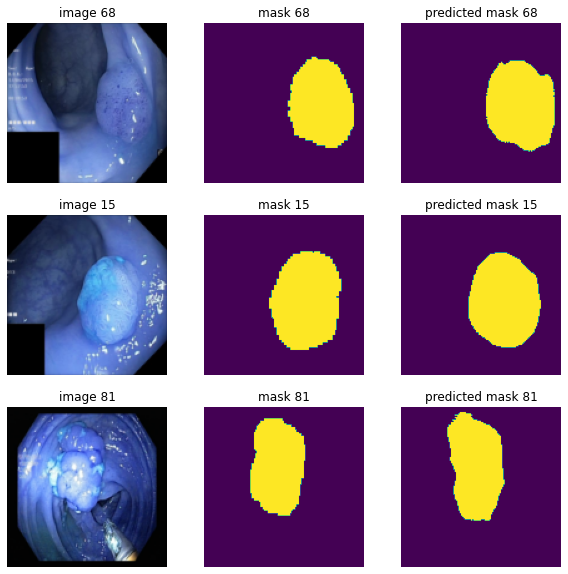

In [61]:
model_visualization(X_test, Y_test, Y_pred_ded)

### Res-U-Net

In [63]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = keras.layers.Add()([conv, shortcut])

    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [64]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))
    
    # Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)

    e3 = residual_block(e2, f[2], strides=2)

    e4 = residual_block(e3, f[3], strides=2)

    e5 = residual_block(e4, f[4], strides=2)
    
    # Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    # Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [65]:
checkpointer3 = tf.keras.callbacks.ModelCheckpoint('ResUNet-model.h5', verbose=1, save_best_only=True)
callbacks3 = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]

ResUNet_model = ResUNet()
ResUNet_results = ResUNet_model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=callbacks3)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 128, 128, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d_76[0][0]']              
 alization)                     )                                                           

ResUNet's results

In [83]:
Y_pred_resunet, df = model_evaluation(ResUNet_model, X_train, X_test, Y_test, "ResUNet")
models_results["ResUNet"] = df

4/4 [==============================] - 8s 2s/step
Evaluate on test data...
1/1 [==============================] - 13s 13s/step - loss: 0.4165 - accuracy: 0.9162
         Accuracy  Precision  Recall  Dice_Coefficient  \
ResUNet     91.62      93.65   78.55             84.35   

         Intersection_over_Union  
ResUNet                    71.45  


Check created masks of test data with ResUNet

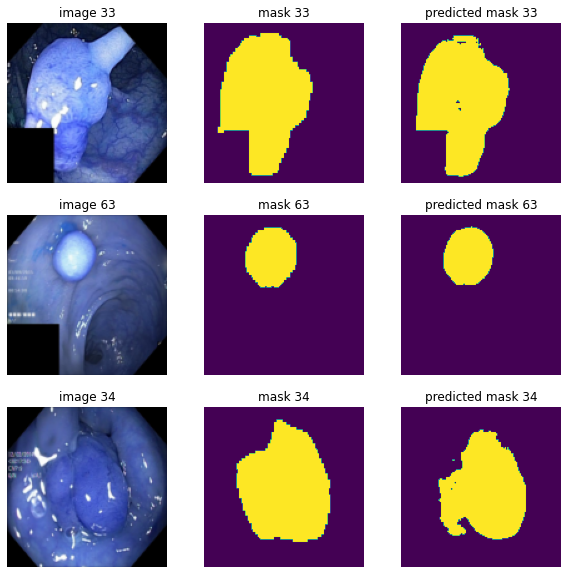

In [77]:
model_visualization(X_test, Y_test, Y_pred_resunet)

### Compare model’s performance

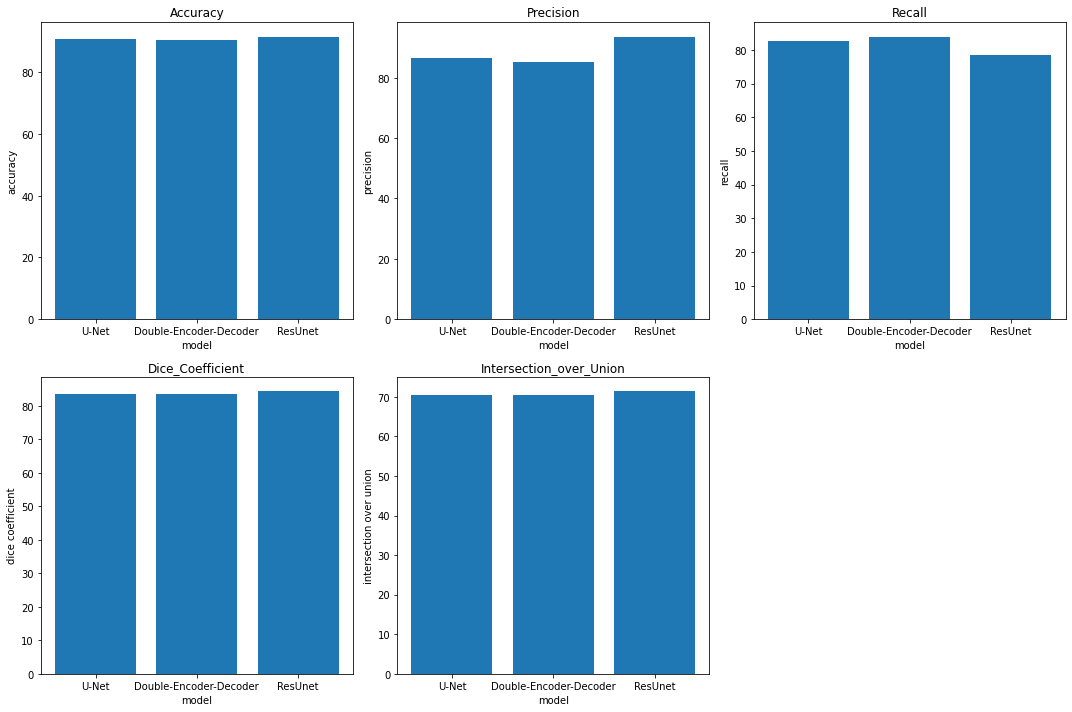

In [102]:
accuracy_list, precision_list, recall_list, Dice_list, IoU_list = [], [], [], [], []

models_lists = ["U-Net", "Double-Encoder-Decoder", "ResUnet"]
for key in models_results.keys():
    accuracy_list.append(models_results[key]["Accuracy"][0])
    precision_list.append(models_results[key]["Precision"][0])
    recall_list.append(models_results[key]["Recall"][0])
    Dice_list.append(models_results[key]["Dice_Coefficient"][0])
    IoU_list.append(models_results[key]["Intersection_over_Union"][0])


plt.figure(figsize=(15, 10))

# accuracy plot
plt.subplot(2, 3, 1)
plt.bar(models_lists, accuracy_list)
plt.title ('Accuracy')
plt.xlabel ('model')
plt.ylabel ('accuracy')

# precision plot
plt.subplot(2, 3, 2)
plt.bar(models_lists, precision_list)
plt.title ('Precision')
plt.xlabel ('model')
plt.ylabel ('precision')

# recall plot
plt.subplot(2, 3, 3)
plt.bar(models_lists, recall_list)
plt.title ('Recall')
plt.xlabel ('model')
plt.ylabel ('recall')

# Dice_Coefficient plot
plt.subplot(2, 3, 4)
plt.bar(models_lists, Dice_list)
plt.title ('Dice_Coefficient')
plt.xlabel ('model')
plt.ylabel ('dice coefficient')

# IoU plot
plt.subplot(2, 3, 5)
plt.bar(models_lists, IoU_list)
plt.title ('Intersection_over_Union')
plt.xlabel ('model')
plt.ylabel ('intersection over union')

plt.tight_layout ()
plt.show ()

History of each model

<Figure size 432x288 with 0 Axes>

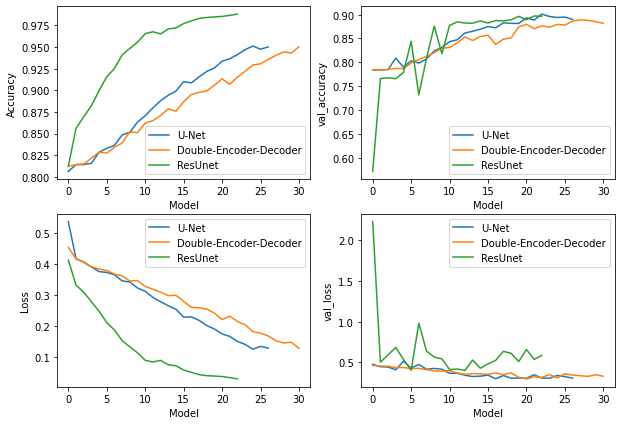

<Figure size 432x288 with 0 Axes>

In [117]:
histories = [U_Net_results, DED_results, ResUNet_results]

plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1)
for history in histories:
    plt.plot(history.history['accuracy'], )
    # plt.plot(history.history['val_accuracy'])

plt.legend(models_lists, loc='lower right')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
for history in histories:
    plt.plot(history.history['val_accuracy'])

plt.legend(models_lists, loc='lower right')
plt.xlabel('Model')
plt.ylabel('val_accuracy')

plt.subplot(2, 2, 3)
for history in histories:
    plt.plot(history.history['loss'])

plt.legend(models_lists, loc='upper right')
plt.xlabel('Model')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
for history in histories:
    plt.plot(history.history['val_loss'])

plt.legend(models_lists, loc='upper right')
plt.xlabel('Model')
plt.ylabel('val_loss')

plt.figure()


Compair some of the predicted masks for each model

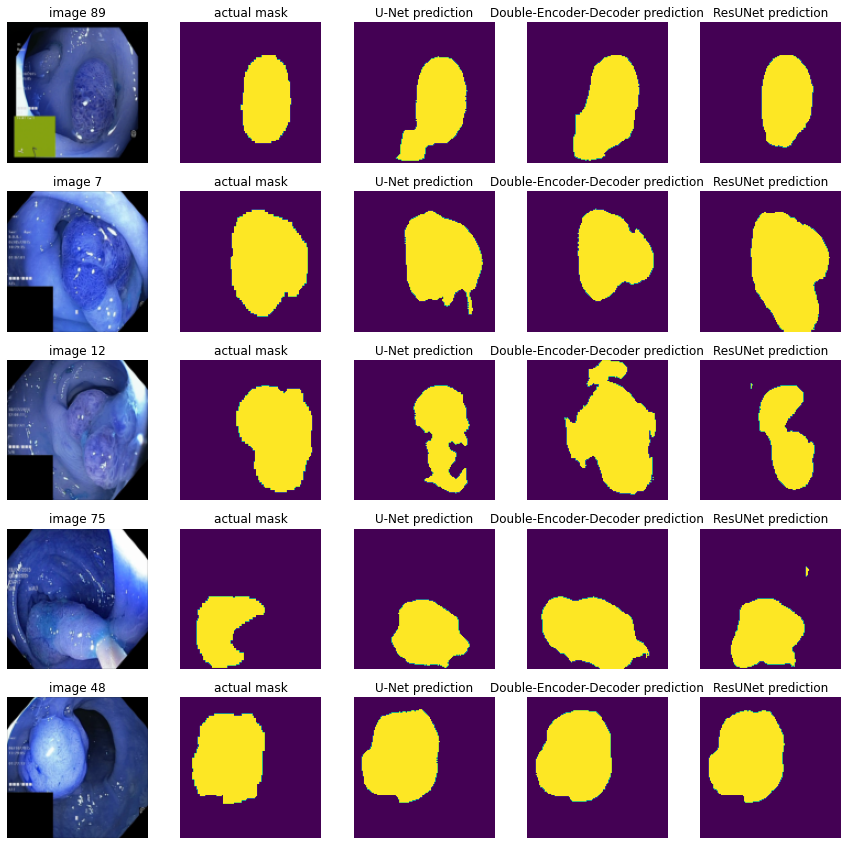

In [128]:
plt.figure(figsize=(15, 15))

for i in range(5):
    x1 = random.randint(0, 99)
    plt.subplot(5, 5, (i*5)+1)
    plt.imshow(X_test[x1]) 
    plt.axis('off') 
    plt.title(f"image {x1}") 
    plt.subplot(5, 5, (i*5)+2)
    plt.imshow(Y_test[x1]) 
    plt.axis('off') 
    plt.title(f"actual mask") 
    plt.subplot(5, 5, (i*5)+3)
    plt.imshow(Y_pred_unet[x1]) 
    plt.axis('off') 
    plt.title(f"U-Net prediction") 
    plt.subplot(5, 5, (i*5)+4)
    plt.imshow(Y_pred_ded[x1]) 
    plt.axis('off') 
    plt.title(f"Double-Encoder-Decoder prediction") 
    plt.subplot(5, 5, (i*5)+5)
    plt.imshow(Y_pred_resunet[x1]) 
    plt.axis('off') 
    plt.title(f"ResUNet prediction") 


plt.show()